# 기계학습 (60점)

### 비트코인 데이터

데이터 경로 : './data/bitcoin_mock.csv'

1분간격의 비트코인 가격에 대한 정보이다. 
- datetime: 1분 단위의 데이터
- open : 시작가
- high : 최고가
- low : 최저가
- close : 종가
- volume : 거래량

In [1075]:
import pandas as pd

In [1076]:
df =pd.read_csv('./data/bitcoin_mock.csv')
df.head()

,datetime,open,high,low,close,volume
0,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574
1,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106
2,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955
3,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894
4,2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029


### 기계학습1
모든 데이터 행이 1분간격으로 존재하는지 확인하고 그렇지 않은 경우 누락된 시각의 행을 생성하고 컬럼들의 결측치를 적절히 생성하라.      
결측치가 존재한다면 결측치를 처리하라

In [1078]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613128 entries, 0 to 613127
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   datetime  613128 non-null  object 
 1   open      613115 non-null  float64
 2   high      613128 non-null  float64
 3   low       613128 non-null  float64
 4   close     613106 non-null  float64
 5   volume    613128 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.1+ MB


In [1079]:
df.datetime = pd.to_datetime(df.datetime)

- 1분 간격으로 존재하지 않는 데이터가 25개 존재한다.
- 시계열데이터이므로 interpolate(보간법)을 이용하여 누락된 시각의 행을 생성한다. 

In [1081]:
df.datetime.diff(1).value_counts(dropna = False)

datetime
0 days 00:01:00    613102
0 days 00:02:00        25
NaT                     1
Name: count, dtype: int64

In [1082]:
import datetime

In [1083]:
new_data = pd.DataFrame(df.datetime.loc[df.datetime.diff(1).dt.seconds == 120] - datetime.timedelta(minutes = 1), columns = ['datetime']).reset_index(drop = True)

In [1084]:
df1_1 = pd.concat([df, new_data], axis = 0).sort_values(by = 'datetime').reset_index(drop = True)
df1_1 = df1_1.interpolate()

In [1085]:
df1_1.isnull().sum()

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

### 기계학습2

t(분)까지 데이터가 확정된 시점에서 매도,매수를 판단하기 위한 알고리즘을 만들고 백테스팅을 진행하려한다.       
아래의 과정의 전처리를 시행하고 algorithm과 result 두 범주형 컬럼의 교차테이블을 출력하라

---
알고리즘
1. t(분)시점에서 t(분)시점과 t-1(분)시점의 5분,120분 이동평균값을 't_5', 't_120'으로 컬럼을 만들어 구한다.
---
2. - t의 5분 이동평균값은 120분 이동평균값보다 높고 t-1의 5분 이동평균값은 120분 이동평균값보다 낮은 경우 : 'buy'   # 매수  
   - t의 5분 이동평균값은 120분 이동평균값보다 낮고 t-1의 5분 이동평균값은 120분 이동평균값보다 높은 경우 : 'sell'  # 매도
   - 그외 'stay'    
   
   위의 조건으로 buy(매수), sell(매도)를 판단하고 buy,sell,stay를 나타내는 새로운 컬럼 'algorithm'을 생성한다.
---         
3. t+10(분)의 open 값과 t(분)의 close값을 비교하여 새로운 컬럼 'result'를 만든다.
   - 여부가 'buy' 이고 t+10(분) open >= t(분) close : 'profit'
   - 여부가 'buy' 이고 t+10(분) open <  t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open >= t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open <  t(분) close : 'profit'
   - 여부가 'stay' 이면 : 'stay' 
   
   위의 조건으로 컬럼값을 채운다

In [1237]:
df1_1.close

datetime
2022-01-01 00:00:00    46250.00
2022-01-01 00:01:00    46312.76
2022-01-01 00:02:00    46368.73
2022-01-01 00:03:00    46331.08
2022-01-01 00:04:00    46321.34
                         ...   
2023-03-02 19:08:00    23475.35
2023-03-02 19:09:00    23460.44
2023-03-02 19:10:00    23482.77
2023-03-02 19:11:00    23477.79
2023-03-02 19:12:00    23453.45
Name: close, Length: 613153, dtype: float64

In [1239]:
df1_1.close.rolling(2).mean()

datetime
2022-01-01 00:00:00          NaN
2022-01-01 00:01:00    46281.380
2022-01-01 00:02:00    46340.745
2022-01-01 00:03:00    46349.905
2022-01-01 00:04:00    46326.210
                         ...    
2023-03-02 19:08:00    23475.730
2023-03-02 19:09:00    23467.895
2023-03-02 19:10:00    23471.605
2023-03-02 19:11:00    23480.280
2023-03-02 19:12:00    23465.620
Name: close, Length: 613153, dtype: float64

In [1087]:
df1_1 = df1_1.set_index('datetime')

In [1088]:
df1_1['t_5'] = df1_1['close'].rolling(6).mean()
df1_1['t_120'] = df1_1['close'].rolling(121).mean()

In [1089]:
df1_1.loc[(df1_1.t_5 > df1_1.t_120) & (df1_1.t_5.shift(1) < df1_1.t_120.shift(1)) == True,'algorithm'] = 'buy'

In [1090]:
df1_1.loc[(df1_1.t_5 < df1_1.t_120) & (df1_1.t_5.shift(1) > df1_1.t_120.shift(1)) == True,'algorithm'] = 'sell'

In [1091]:
df1_1.algorithm = df1_1.algorithm.fillna('stay')

In [1092]:
df1_1.algorithm.value_counts()

algorithm
stay    599697
sell      6728
buy       6728
Name: count, dtype: int64

In [1229]:
df1_1.loc[pd.to_datetime('2022-01-01 13:30:00'):pd.to_datetime('2022-01-01 13:50:00'),:]

,open,high,low,close,volume,t_5,t_120,algorithm,result
datetime,,,,,,,,,
2022-01-01 13:30:00,47022.59,47050.00,47022.58,47039.90,4.49692,47031.270000,46989.449669,stay,stay
2022-01-01 13:31:00,47039.91,47046.44,46992.82,47000.01,5.59073,47027.381667,46989.726116,stay,stay
2022-01-01 13:32:00,47000.00,47000.01,46988.85,46999.98,3.37117,47024.735000,46990.474050,stay,stay
2022-01-01 13:33:00,46999.98,47000.00,46935.09,46975.61,23.68727,47014.331667,46991.024793,stay,stay
2022-01-01 13:34:00,46975.55,46986.43,46969.58,46983.83,5.46064,47003.653333,46991.927438,stay,stay
2022-01-01 13:35:00,46983.82,46988.17,46965.00,46988.17,3.92075,46997.916667,46992.688182,stay,stay
2022-01-01 13:36:00,46983.82,47048.53,46983.82,47045.43,6.10855,46998.838333,46993.929917,stay,stay
2022-01-01 13:37:00,47045.43,47066.00,47036.44,47060.29,5.85450,47008.885000,46995.659504,stay,stay
2022-01-01 13:38:00,47060.29,47064.99,47046.32,47060.29,4.37955,47018.936667,46997.207025,stay,stay


In [1093]:
df1_1.loc[(df1_1.algorithm == 'buy') & (df1_1.open.shift(-10) >= df1_1.close), 'result'] = 'profit'

In [1094]:
df1_1.loc[(df1_1.algorithm == 'buy') & (df1_1.open.shift(-10) < df1_1.close), 'result'] = 'loss'

In [1095]:
df1_1.loc[(df1_1.algorithm == 'sell') & (df1_1.open.shift(-10) >= df1_1.close), 'result'] = 'loss'

In [1096]:
df1_1.loc[(df1_1.algorithm == 'sell') & (df1_1.open.shift(-10) < df1_1.close), 'result'] = 'profit'

In [1097]:
df1_1.loc[df1_1.algorithm == 'stay', 'result'] = 'stay'

In [1098]:
df1_1.result.value_counts(dropna = False)

result
stay      599697
loss        6958
profit      6498
Name: count, dtype: int64

In [1241]:
pd.crosstab(index = df1_1.algorithm, columns = df1_1.result)

result,loss,profit,stay
algorithm,,,
buy,3427,3301,0
sell,3531,3197,0
stay,0,0,599697


### 기계학습3     
위에서 전처리한 데이터에 대해 아래 조건으로 그래프를 출력하라
1. 2022-01-01 08:00:00 ~ 2022-01-01 15:00:00 시간대의 close값의 선형 그래프
2. 위 시간대에 대해 algorithm 컬럼이 buy일 경우 빨간 수직선, sell일 경우 파란 수직선

<img src="./data/1.png" height='300' width='1200' style="float: left; margin-right: 10px;">

In [1100]:
import matplotlib.pyplot as plt

In [1161]:
target = df1_1.loc[pd.to_datetime('2022-01-01 08:00:00'):pd.to_datetime('2022-01-01 15:00:00'),:]

In [1223]:
target.index.strftime('%H:%M')

Index(['08:00', '08:01', '08:02', '08:03', '08:04', '08:05', '08:06', '08:07',
       '08:08', '08:09',
       ...
       '14:51', '14:52', '14:53', '14:54', '14:55', '14:56', '14:57', '14:58',
       '14:59', '15:00'],
      dtype='object', name='datetime', length=421)

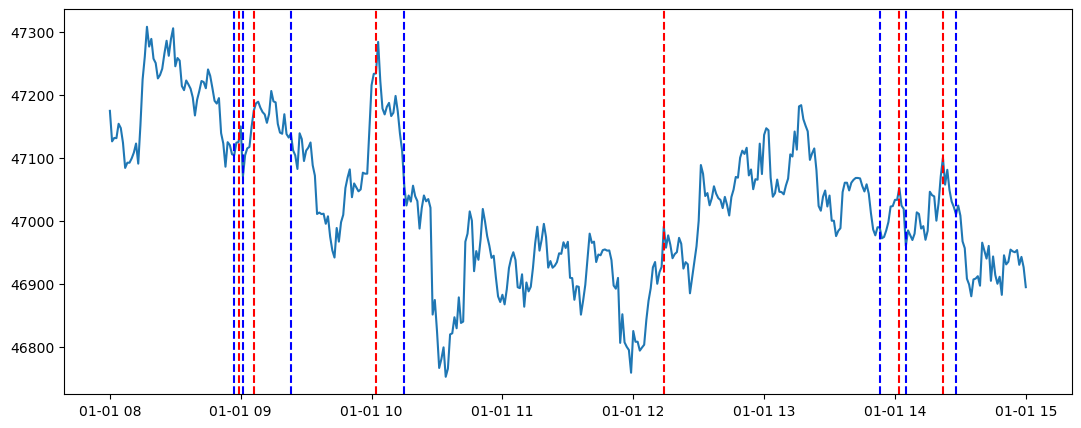

In [1227]:
plt.figure(figsize = (13, 5))
plt.plot(target.close)
for idx in target.loc[target.algorithm == 'buy'].index:
    plt.axvline(idx, color = 'r', linestyle = '--')
for idx in target.loc[target.algorithm == 'sell'].index:
    plt.axvline(idx, color = 'b', linestyle = '--')
plt.show()

### 기계학습4
아래의 정의된 컬럼들로 result의 loss와 profit을 예측하는 모델을 만들려고 한다.

- open
- 시작가,종가 가격차이 (open - close)
- algorithm
- t분과 t-5시점의 close값의 차이 (t , t-5)

2022년 2월 ~ 12월까지의 데이터를 train  2023년 1~2월의 데이터를 평가 데이터로 하고 result의 값이 loss,profit인 데이터만 학습에 사용하여     
랜덤포레스트와 서포트 벡터머신 분류모델을 만들고 test데이터에 대해 accuracy를 비교하라. test데이터에 대한 예측 진행시 profit일 확률이 60%이상인 경우에만 profit으로 예측한다

In [350]:
df1_1['price_gap'] = df1_1.close - df1_1.open

In [360]:
df1_1['close_gap'] = df1_1.close.diff(5)

In [421]:
train_df = df1_1.loc[pd.to_datetime('2022-02-01 00:00:00'):pd.to_datetime('2022-12-31 23:59:00'),:]
train_df = train_df.loc[train_df.result.isin(['loss','profit']),['open','price_gap','algorithm','close_gap','result']]

In [423]:
test_df = df1_1.loc[pd.to_datetime('2023-01-01 00:00:00'):pd.to_datetime('2023-02-28 23:59:00'),['open','price_gap','algorithm','close_gap','result']]

In [1247]:
test_df

,open,price_gap,close_gap,result,algorithm_buy,algorithm_sell,algorithm_stay
datetime,,,,,,,
2023-01-01 00:00:00,16541.77,1.90,4.39,NaN,0,0,1
2023-01-01 00:01:00,16543.04,-3.73,-1.21,NaN,0,0,1
2023-01-01 00:02:00,16539.31,-2.88,-1.35,NaN,0,0,1
2023-01-01 00:03:00,16536.43,-2.78,-2.77,NaN,0,0,1
2023-01-01 00:04:00,16534.12,1.26,-7.02,NaN,0,0,1
...,...,...,...,...,...,...,...
2023-02-28 23:55:00,23124.18,-7.93,-31.19,NaN,0,0,1
2023-02-28 23:56:00,23115.30,5.92,-29.55,NaN,0,0,1
2023-02-28 23:57:00,23121.73,-0.31,-23.47,NaN,0,0,1


- 범주형 데이터가 있으므로 레이블 인코딩을 진행한다.
- train데이터에 algorithm = 'stay'가 없으므로 테스트데이터에서 해당 칼럼을 삭제하고 해당 레이블을 0으로 표시한다.

In [427]:
train_df = pd.get_dummies(train_df, columns = ['algorithm'], dtype = int)

In [433]:
train_df.result = train_df.result.map({'loss':0,'profit':1})

In [443]:
X_train = train_df.drop(columns = 'result')

In [462]:
X_train

,open,price_gap,close_gap,algorithm_buy,algorithm_sell
datetime,,,,,
2022-02-01 00:01:00,38404.73,-79.83,-175.10,0,1
2022-02-01 00:09:00,38531.06,64.65,162.87,1,0
2022-02-01 00:18:00,38372.29,-55.96,-210.24,0,1
2022-02-01 02:17:00,38333.50,6.43,37.65,1,0
2022-02-01 04:32:00,38480.20,14.27,-10.43,0,1
...,...,...,...,...,...
2022-12-31 19:37:00,16585.34,-2.67,7.79,1,0
2022-12-31 19:56:00,16575.11,-5.42,-14.26,0,1
2022-12-31 22:15:00,16564.95,-2.22,0.24,1,0


In [445]:
y_train = train_df['result']

In [437]:
test_df = pd.get_dummies(test_df, columns = ['algorithm'], dtype = int)

In [439]:
test_df.result = test_df.result.map({'loss':0,'profit':1})

In [467]:
X_test = test_df.drop(columns = ['result','algorithm_stay'])

In [469]:
X_test

,open,price_gap,close_gap,algorithm_buy,algorithm_sell
datetime,,,,,
2023-01-01 00:00:00,16541.77,1.90,4.39,0,0
2023-01-01 00:01:00,16543.04,-3.73,-1.21,0,0
2023-01-01 00:02:00,16539.31,-2.88,-1.35,0,0
2023-01-01 00:03:00,16536.43,-2.78,-2.77,0,0
2023-01-01 00:04:00,16534.12,1.26,-7.02,0,0
...,...,...,...,...,...
2023-02-28 23:55:00,23124.18,-7.93,-31.19,0,0
2023-02-28 23:56:00,23115.30,5.92,-29.55,0,0
2023-02-28 23:57:00,23121.73,-0.31,-23.47,0,0


In [528]:
y_test = test_df['result'].fillna(0)

- 랜덤포레스트 모델링

In [458]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [454]:
rf_model = RandomForestClassifier()

In [456]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [483]:
rf_pred = rf_model.predict_proba(X_test)[:,0]

In [495]:
rf_pred = pd.DataFrame(rf_pred, columns = ['rf_pred']).map(lambda x : 1 if x >= 0.6 else 0)
rf_pred

,rf_pred
0,0
1,0
2,0
3,0
4,0
...,...
84955,0
84956,0
84957,0
84958,0


- 서포트벡터머신 모델링

In [498]:
from sklearn.svm import SVC

In [500]:
svc_model = SVC(probability = True)

In [504]:
svc_model.fit(X_train, y_train)

SVC(probability=True)

In [512]:
svc_pred = svc_model.predict_proba(X_test)

In [518]:
svc_pred = pd.DataFrame(svc_pred[:,0], columns = ['svc_pred']).map(lambda x : 1 if x >= 0.6 else 0)
svc_pred

,svc_pred
0,0
1,0
2,0
3,0
4,0
...,...
84955,0
84956,0
84957,0
84958,0


- 모델링 성능 비교
    - 모델링 결과 랜덤포레스트 모델의 Accuracy는 0.79, 서포트벡터머신의 Accuracy는 0.99로 서포트벡터머신의 정확도가 우수한 것으로 나타난다.

In [541]:
rf_accuracy = accuracy_score(y_test, rf_pred)

rf_accuracy

0.7904190207156309

In [535]:
svc_accuracy = accuracy_score(y_test, svc_pred)
svc_accuracy

0.9895009416195857

### 유저의 카드사용 데이터

데이터 출처 :https://www.kaggle.com/datasets/arjunbhasin2013/ccdata     
dataurl ='./data/user_data.csv'

다음은 Credit Card 데이터셋의 데이터 사전 및 각 컬럼의 한글 번역입니다:

1. **CUST_ID**: 신용카드 보유자 식별

2. **BALANCE**: 계좌에 남아 있는 구매 가능 잔액

3. **BALANCE_FREQUENCY**: 잔액 업데이트 빈도, 0과 1 사이의 점수 (1 = 자주 업데이트됨, 0 = 자주 업데이트되지 않음)

4. **PURCHASES**: 계좌에서의 구매 금액

5. **ONEOFF_PURCHASES**: 한 번에 최대 구매 금액

6. **INSTALLMENTS_PURCHASES**: 할부로 구매한 금액

7. **CASH_ADVANCE**: 사용자가 미리 지급한 현금

8. **PURCHASES_FREQUENCY**: 구매 빈도, 0과 1 사이의 점수 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

9. **ONEOFFPURCHASESFREQUENCY**: 일회성 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

10. **PURCHASESINSTALLMENTSFREQUENCY**: 할부 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

11. **CASHADVANCEFREQUENCY**: 현금 선지급 빈도 (1 = 자주 선지급함, 0 = 자주 선지급하지 않음)

12. **CASHADVANCETRX**: 현금 선지급으로 이루어진 거래 수

13. **PURCHASES_TRX**: 구매 거래 수

14. **CREDIT_LIMIT**: 사용자 신용카드의 한도

15. **PAYMENTS**: 사용자가 지불한 금액

16. **MINIMUM_PAYMENTS**: 사용자가 지불한 최소 금액

17. **PRCFULLPAYMENT**: 사용자가 지불한 전체 금액의 백분율

18. **TENURE**: 신용카드 서비스 사용 기간

In [544]:
import pandas as pd
df2 = pd.read_csv('./data/user_data.csv')
df2.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### 기계학습
데이터 EDA를 실시하고 결측치와 이상치를 처리하라 (시각화 포함)

- 데이터가 전반적으로 한쪽으로 치우쳐져있는 경향이 강하다.
- 즉, 이상치로 분류될 수 있는 데이터가 많다.

In [556]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

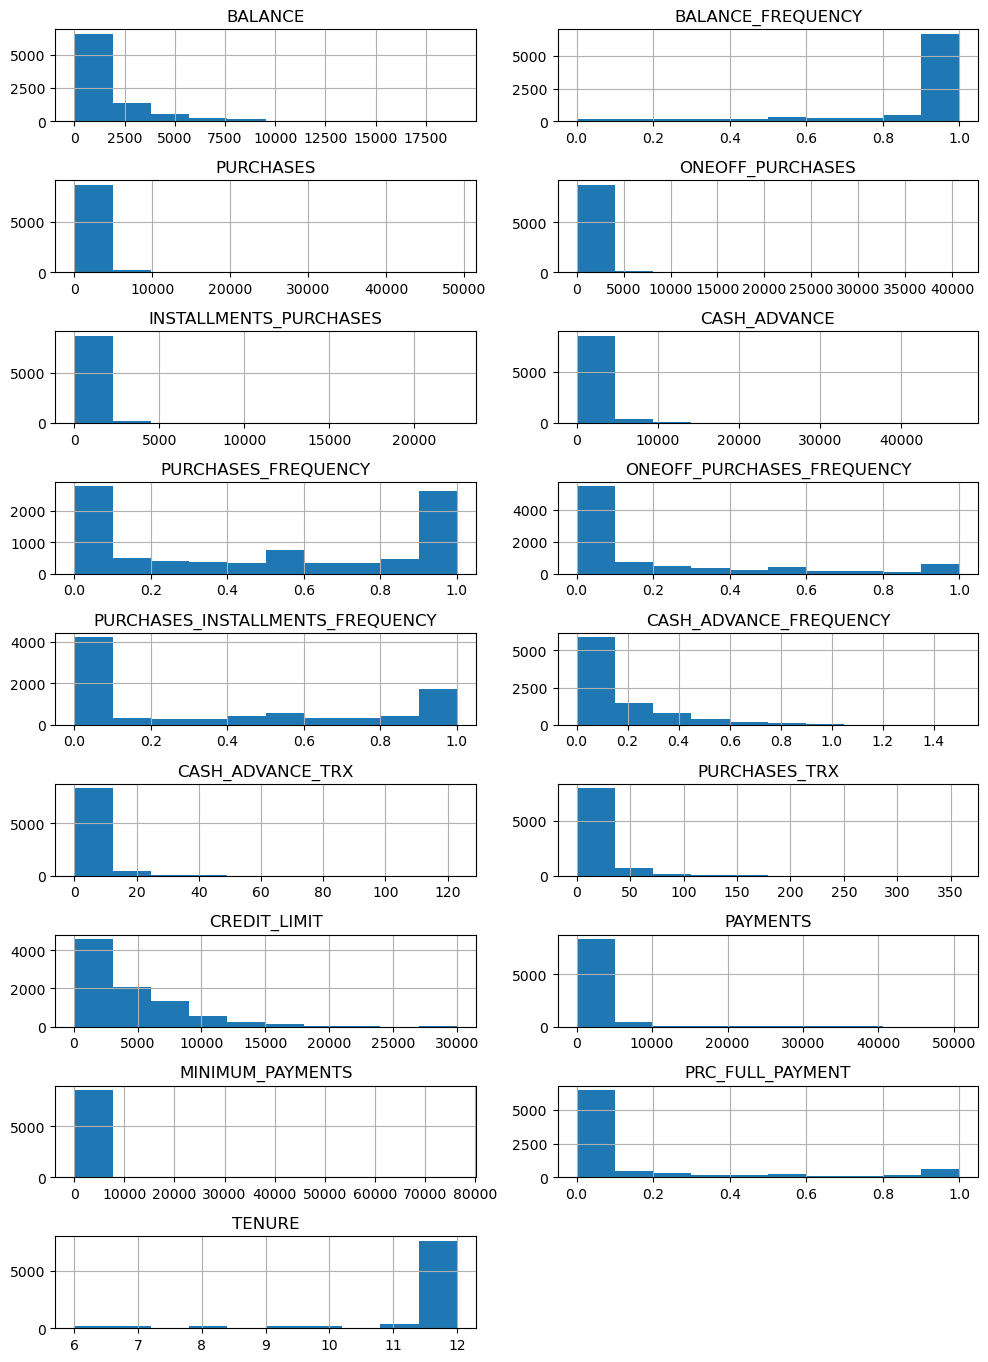

In [572]:
num_var = df2.select_dtypes(include = 'number').columns

plt.figure(figsize = (10, 15))
for i in range(len(num_var)):
    plt.subplot(10,2,i+1)
    df2[num_var[i]].hist()
    plt.title(num_var[i])
plt.tight_layout()
plt.show()

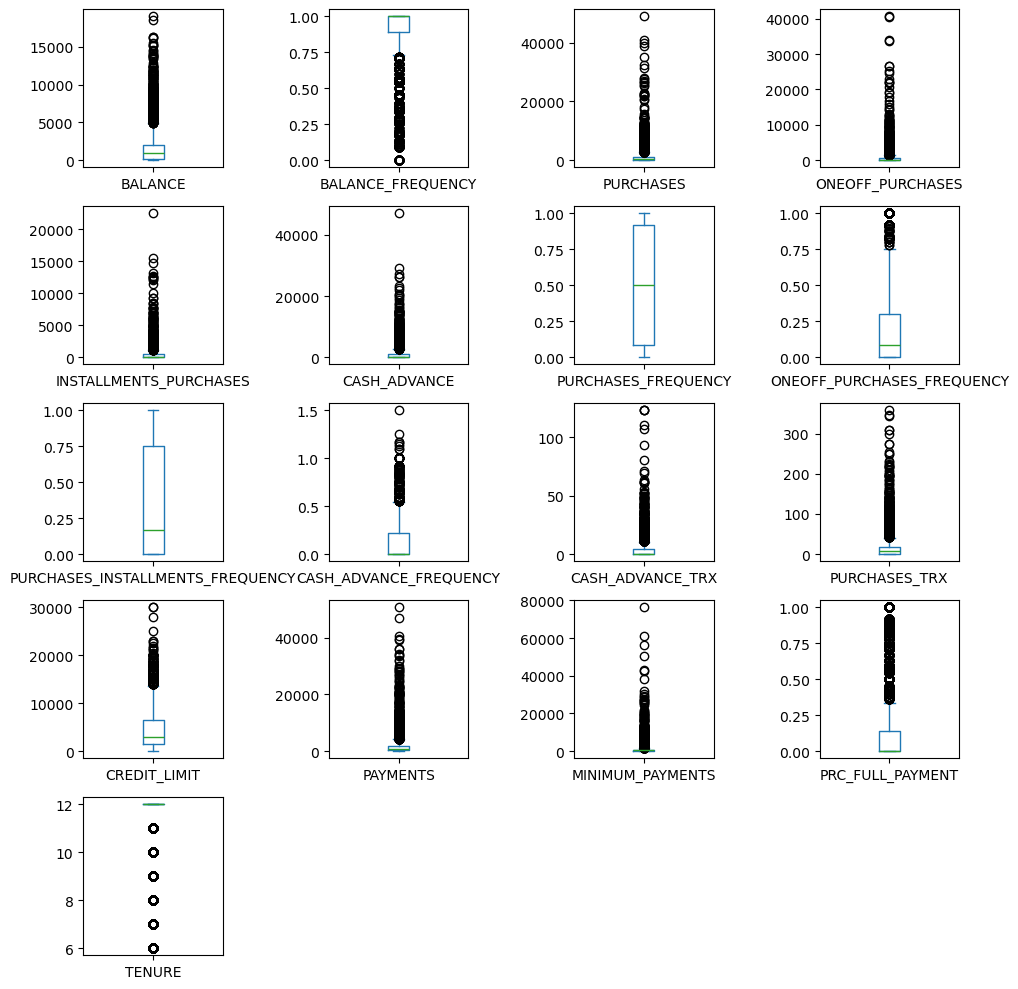

In [582]:
df2[num_var].plot(kind = 'box', subplots = True, layout = (5, 4), figsize = (10, 10))
plt.tight_layout()

- 결측치 처리
  - MINIMUM_PAYMENTS 변수에 결측치가 확인된다.
  - 해당 변수는 사용자가 지불한 최소금액으로 실제 지불금액(PAYMENTS)도 대부분 0인 것이 확인된다.
  - 따라서 결측치를 0으로 대체하기로 한다.

In [587]:
df2.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [610]:
df2.loc[df2.MINIMUM_PAYMENTS.isnull()].PAYMENTS.value_counts()

PAYMENTS
0.000000       240
861.744611       1
127.996550       1
198.562574       1
382.210790       1
              ... 
368.807294       1
2437.932505      1
692.523718       1
415.603589       1
275.861322       1
Name: count, Length: 74, dtype: int64

In [613]:
df2.loc[df2.MINIMUM_PAYMENTS.isnull(), 'MINIMUM_PAYMENTS'] = 0

- 이상치 처리
  - 데이터의 분포가 치우쳐져있으므로 큰 데이터를 이상치로 간주하기보다 분석에 활용하는 것이 적절해보인다.
  - Q1,Q3에서 IQR의 3배를 초과한 범위의 데이터를 이상치로 보고 제거한다.

In [632]:
get_outlier_idx(df2.PAYMENTS)

In [638]:
def get_outlier_idx(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    IQR = q3 - q1

    outlier_idx = x[(x > q3 + IQR*3) | (x < q1 - IQR*3)].index

    return list(outlier_idx)

In [642]:
outlier_index = []

for col in num_var:
    outlier_index.extend(get_outlier_idx(df2[col]))

In [644]:
outlier_index = set(outlier_index)

In [652]:
list(outlier_index)

[1,
 8194,
 8195,
 6,
 9,
 12,
 8204,
 8208,
 17,
 8209,
 8211,
 8212,
 8213,
 21,
 8215,
 23,
 8217,
 19,
 8219,
 20,
 8221,
 30,
 8223,
 8224,
 8225,
 8226,
 8227,
 36,
 8229,
 8230,
 39,
 34,
 8234,
 8237,
 46,
 8239,
 48,
 8241,
 50,
 8243,
 8238,
 8245,
 53,
 8247,
 8240,
 8249,
 57,
 8251,
 8252,
 58,
 62,
 63,
 8256,
 8257,
 64,
 8259,
 68,
 8255,
 8261,
 71,
 8264,
 8265,
 8263,
 66,
 8268,
 72,
 78,
 79,
 8272,
 81,
 8274,
 83,
 84,
 8277,
 86,
 87,
 85,
 89,
 90,
 91,
 8284,
 8283,
 8280,
 95,
 8281,
 8289,
 98,
 99,
 8291,
 101,
 8293,
 103,
 8294,
 8297,
 8296,
 107,
 102,
 109,
 8300,
 8302,
 112,
 113,
 114,
 8303,
 116,
 8309,
 118,
 8308,
 120,
 8313,
 122,
 8315,
 124,
 125,
 8317,
 24,
 128,
 129,
 130,
 8321,
 131,
 133,
 8325,
 8327,
 136,
 8329,
 138,
 8326,
 8332,
 8333,
 8331,
 143,
 8336,
 144,
 8337,
 8339,
 150,
 8343,
 151,
 153,
 152,
 155,
 156,
 157,
 158,
 8351,
 8349,
 154,
 8345,
 8355,
 8348,
 164,
 166,
 167,
 8352,
 8361,
 170,
 171,
 172,
 8364,
 17

In [660]:
df2_2 = df2.copy()
df2_2 = df2_2.drop(index = outlier_index).reset_index(drop = True)

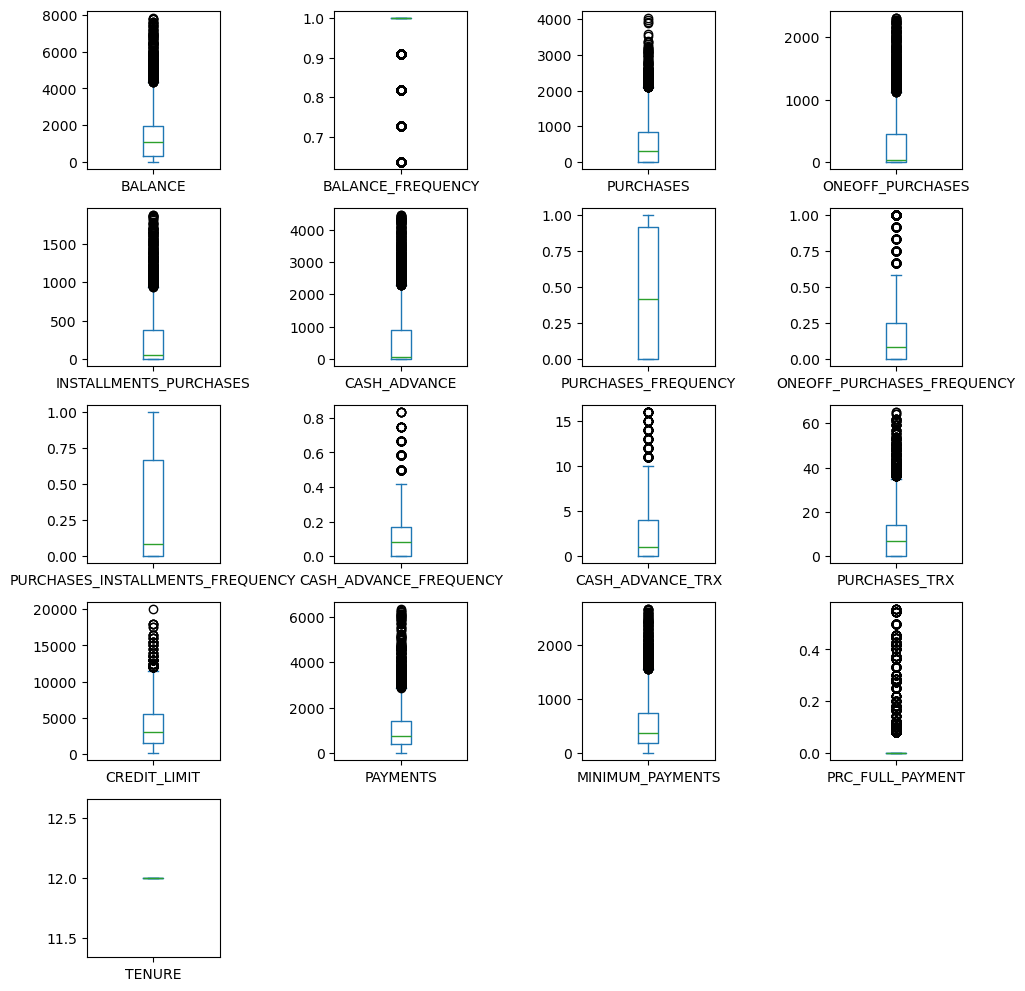

In [662]:
df2_2[num_var].plot(kind = 'box', subplots = True, layout = (5, 4), figsize = (10, 10))
plt.tight_layout()

### 기계학습6     
PCA를 통해 적절한 차원으로 데이터를 축소하고 평가하라

- 자료 왜곡 방지를 위해 데이터 스케일링을 선행한다.
- 자료 변동의 80% 이상을 설명하는 PCA 5개가 적절한 것으로 판단된다.

In [755]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [761]:
mm = MinMaxScaler()

In [763]:
df2_2_mm = mm.fit_transform(df2_2.iloc[:,1:])

In [664]:
from sklearn.decomposition import PCA

In [697]:
pca = PCA(n_components=8)

In [765]:
pca.fit(df2_2_mm)

PCA(n_components=8)

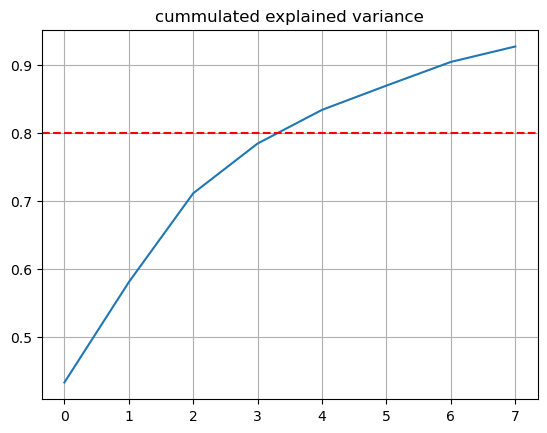

In [767]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axhline(y = 0.8, color = 'red', linestyle = '--')
plt.grid()
plt.title('cummulated explained variance')
plt.show()

In [769]:
pca_final = PCA(n_components=4)

In [771]:
df2_4_1 = pd.DataFrame(pca_final.fit_transform(df2_2_mm), columns = [f'PCA{i}' for i in range(1, 5)])

### 기계학습7     
위의 차원 축소된 데이터를 바탕으로 KMeans 클러스터링을 실시하라.     
응집도와 분리도를 기반으로 적절 클러스터 숫자를 구하고 두개의 주성분 차원에 군집 중심을 포함하여 시각화하라

- 응집도와 분리도 기반 클러스터는 WWCS를 통해 확인할 수 있다.
- WWCS는 군집 중심과 데이터 거리의 오차제곱합으로, 응집도와 분리도가 높을수록 감소한다.
- 군집별 WWCS 확인 결과 군집 3개 이후 지표 감소 폭이 줄어든 것이 확인되므로 효율적 군집을 위해 군집 수를 3개로 결정한다.
- 군집별 분포를 보면 

In [728]:
from sklearn.cluster import KMeans

In [773]:
sse = []

for i in range(1, 10):
    km = KMeans(n_clusters= i)
    km.fit(df2_4_1)
    sse.append(km.inertia_)

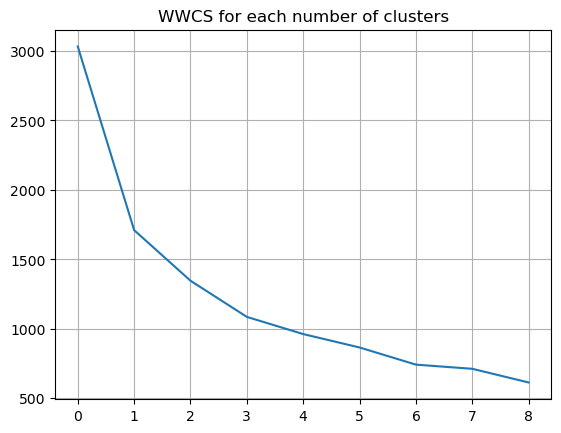

In [774]:
plt.plot(sse)
plt.title('WWCS for each number of clusters')
plt.grid()
plt.show()

In [777]:
final_km = KMeans(n_clusters=3)

In [779]:
df2_4_1['cluster'] = final_km.fit_predict(df2_4_1)

In [749]:
import seaborn as sns

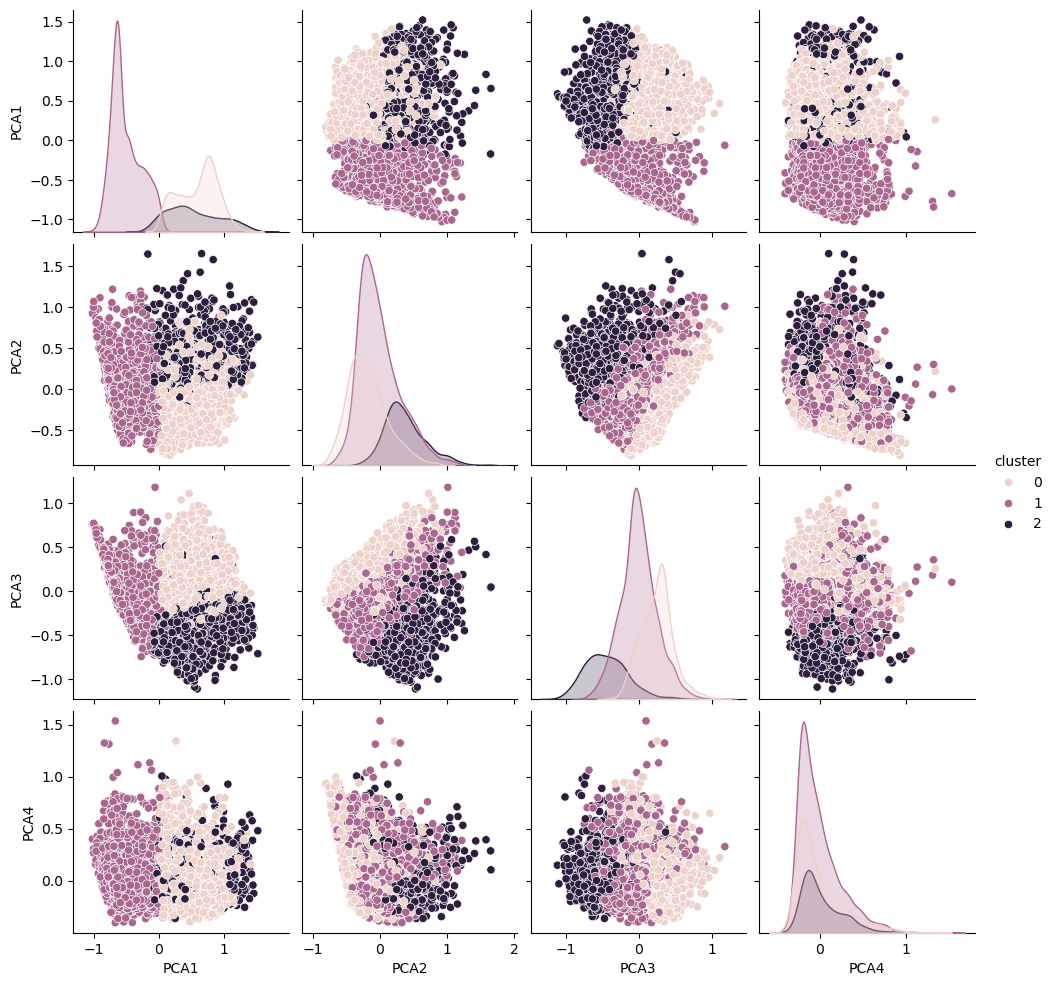

In [781]:
sns.pairplot(df2_4_1, hue = 'cluster')
plt.show()

### 기계학습8   
마케팅 담당자인 당신은 KMeans 군집 결과를 통해 각 군집 특성을 파악하고 군집별 프로모션 전략을 서술하라
    

- (군집 0) 계좌의 잔액은 적은 편이나 구매 빈도나 결제액은 적지 않은 편이며 할부 결제도 많다. 가처분소득 대비 많은 소비를 하는 고객으로 판단되며 향후 연체 위험에 대비할 필요가 있어보인다. 할부 결제 대신 일시불 결제 시 혜택을 주는 프로모션이 필요해보인다.
- (군집 1) 계좌 잔액이 가장 많으나 계좌에서 구매 금액은 적고 현금을 많이 선납하는 고소득 우량고객으로 판단된다. 카드 소비를 촉진하기 위해 해당 군집을 대상으로 카드 사용 시 무이자할부 혜택을 주는 등 프로모션이 가능해보인다.
- (군집 2) 계좌 잔액이 많으면서 구매도 많이 하는 캐시카우 고객이다. 해당 고객이 계속해서 카드 사용을 유지할 수 있도록 멤버십 혜택을 제공하는 것이 적절해보인다.

In [791]:
df2_5 = pd.concat([df2_2, df2_4_1.cluster], axis =1)
df2_5

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,2
2,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.000000,0.000000,12,1
3,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1
4,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,C18980,87.026009,1.000000,605.52,0.00,605.52,0.000000,1.000000,0.000000,0.916667,0.000000,0,12,1500.0,511.637312,175.012705,0.000000,12,0
4449,C18986,16.428326,0.909091,441.50,124.70,316.80,0.000000,1.000000,0.166667,0.916667,0.000000,0,14,1000.0,482.547848,91.328536,0.333333,12,0
4450,C18988,38.015366,1.000000,213.95,0.00,213.95,0.000000,0.916667,0.000000,0.833333,0.000000,0,11,1500.0,163.496451,179.415689,0.444444,12,0
4451,C18998,67.377243,1.000000,295.00,0.00,295.00,0.000000,0.500000,0.000000,0.416667,0.000000,0,6,1000.0,245.689379,167.126034,0.300000,12,0


In [795]:
df2_5.drop(columns = 'CUST_ID').groupby('cluster').mean().T

cluster,0,1,2
BALANCE,939.974062,1715.485014,1518.642542
BALANCE_FREQUENCY,0.961765,0.969620,0.982038
PURCHASES,705.025603,178.247650,1483.604583
ONEOFF_PURCHASES,154.085184,143.519587,1134.042379
INSTALLMENTS_PURCHASES,551.235713,34.912652,349.562204
CASH_ADVANCE,266.100044,865.363609,355.811801
PURCHASES_FREQUENCY,0.843689,0.123847,0.808692
ONEOFF_PURCHASES_FREQUENCY,0.088542,0.073223,0.676299
PURCHASES_INSTALLMENTS_FREQUENCY,0.799387,0.049950,0.375112
CASH_ADVANCE_FREQUENCY,0.055147,0.175713,0.067764


### 기계학습9
병합적 계층군집을 실시하고 덴드로그램을 시각화하라. 군집간 거리는 ward 방식으로 업데이트하며 위 문제에서 구한 최적 군집이 만들어지 지기 위한 거리 범위를 구하라

- KMean에서 구한 최적 군집이 만들어지기 위해서는 와드 거리 범위가 약 22 이상, 약 52 이하인 것으로 나타난다.

In [800]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [802]:
ward = linkage(df2_4_1, method = 'ward')

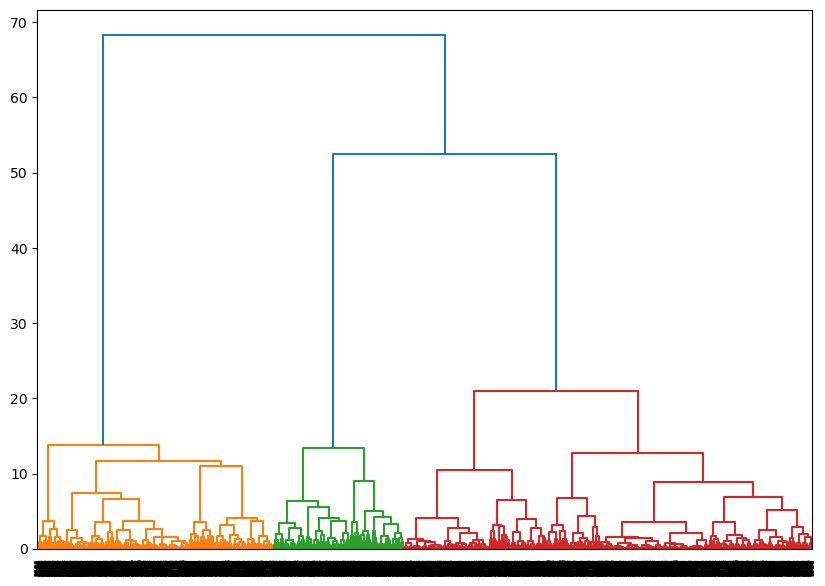

In [816]:
plt.figure(figsize = (10, 7))
dendrogram(ward)
plt.show()

In [845]:
assignments = fcluster(ward, 22, criterion='distance')

In [847]:
pd.Series(assignments).value_counts()

3    2349
1    1360
2     744
Name: count, dtype: int64

In [849]:
assignments = fcluster(ward, 52, criterion='distance')

In [851]:
pd.Series(assignments).value_counts()

3    2349
1    1360
2     744
Name: count, dtype: int64

# 통계 (40점)

### 통계1      
어느 자동차 회사의 본사에서 여러 지방 영업소에 내려보낸 43대의 새 차 중 11대에 불량 오디오가 설치되었다고 한다. 어느 영업소가 8대를 인수하였는데 이 중에서 오디오가 불량인 차가 적어도 2대 이상이 될 확률을 구하라.

- 비복원추출 상황에서 발생 횟수의 확률을 구하므로 초기하분포를 이용한다.
- 오디오가 불량인 차가 적어도 2대 이상이 될 확률은 0.67이다.

In [854]:
from scipy.stats import hypergeom

In [856]:
rv = hypergeom(M = 43, n = 11, N = 8)

In [860]:
1 - rv.cdf(x = 1)

0.6721384488647228

### 통계2
data_path = ./data/stats_reg1.csv     
종속변수 : Target   
독립변수 : 다양한 센서데이터

In [869]:
import pandas as pd
df3=pd.read_csv('./data/stats_reg1.csv')
df3.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,Target
0,0.296120,-1.463515,-0.327662,0.005113,-0.702053,0.097078,-0.392108,0.261055,0.968645,2,3,1.475520,-0.363724,-0.503583,-1.464364,7.709164
1,1.579213,-0.234137,1.523030,-0.469474,0.647689,0.496714,-0.234153,0.767435,-0.138264,2,1,0.387250,0.907459,0.928492,0.938609,264.129513
2,-0.562467,0.707752,-0.626967,0.972554,1.770801,-0.703176,1.812449,0.632408,-0.034988,2,2,0.955285,-0.096463,-0.030130,2.166524,211.602064
3,1.496044,-1.778720,-0.773789,-0.055585,1.876796,1.355638,-1.244655,0.654366,0.413435,2,1,0.441394,0.352448,-0.467829,2.433214,273.654357
4,-0.759133,-0.525755,-0.599393,0.341756,-0.839722,2.189803,-2.123896,0.150394,-0.808298,1,2,0.991974,-0.562178,-0.176573,-0.068282,-158.208708


### 통계2-1
변수들의 다중공선성을 검토하라


- 다중공선성은 독립변수 간 상관관계가 존재하여 회귀분석 시 편회귀계수가 왜곡되는 문제를 의미한다.
- 독립변수가 나머지 변수에 의해 설명되는 정도를 사용해 분산팽창계수(VIF)를 계산하며, VIF > 10인 경우 다중공선성이 있는 것으로 판단한다.
- 검토 결과 F_12, F_11, F_13, F_1, F_2에 다중공선성이 존재하는 것으로 판단된다.

In [863]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [865]:
vif = pd.DataFrame()

In [879]:
vif['VIF_Factor'] = [variance_inflation_factor(df3.iloc[:,:-1], idx) for idx in range(len(df3.columns)-1)]

In [883]:
vif.index = df3.columns[:-1]

In [887]:
vif.sort_values(by = 'VIF_Factor', ascending = False)

,VIF_Factor
F_12,141.201961
F_11,139.715210
F_13,46.388666
F_1,44.238222
F_2,14.524559
F_10,5.828291
F_14,2.840278
F_15,2.294972
F_5,2.195660
F_3,2.101471


### 통계2-2
다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고, 하나를 선택하여 적용하라


- 다중공선성 추정 변수 제거 또는 PCA 등을 이용한 변수 통합 방법이 존재한다.
- 본 분석에서는 해당 변수를 제거하고 분석하도록 한다.

In [891]:
df3_1 = df3.drop(columns = ['F_12', 'F_11', 'F_13', 'F_1', 'F_2'])

### 통계2-3
2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교하라


- 변수 제거 전에는 F_1과 F_2의 회귀계수가 통계적으로 유의미한 것이 확인된다.
- 그러나 이는 F_1과 F_2의 영향이 아닌 해당 변수과 상관관계가 있는 다른 변수의 영향으로 볼 수 있다.
- 또한 다중공선성으로 인해 F_7의 회귀계수는 당초 통계적으로 유의미한 것으로 보였으나 변수 제거 후 통계적 유의성이 낮은 것으로 확인된다.
- 즉 다중공선성 제거를 위해 나머지 변수가 종속변수에 미치는 영향이 분명해지는 것이 확인된다.

In [893]:
import statsmodels.api as sm

In [897]:
X_total = df3.drop(columns = 'Target')

In [899]:
y = df3.Target

In [901]:
X_delete = df3_1.drop(columns = 'Target')

- 변수 제거 전 모델

In [904]:
X_total_constant = sm.add_constant(X_total)

In [912]:
sm_total = sm.OLS(endog=y, exog=X_total_constant).fit()

In [916]:
sm_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.230e+07
Date:                Sat, 24 Aug 2024   Prob (F-statistic):          3.61e-277
Time:                        07:39:50   Log-Likelihood:                 108.69
No. Observations:                 100   AIC:                            -185.4
Df Residuals:                      84   BIC:                            -143.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0314      0.039      0.814      0.418      -0.045       0.108
F_1           61.6675      0.064    957.009      0.000      61.539      61.796
F_2           28.6933      0.035    825.633      0.000      28.624      28.762
F_3           50.7597      0.015   3371.303      0.000      50.730      50.790
F_4           63.1688      0.013   5010.118      0.000      63.144      63.194
F_5           83.1993      0.012   7090.507      0.000      83.176      83.223
F_6           16.0561      0.011   1471.039      0.000      16.034      16.078
F_7            0.6330      0.010     65.170      0.000       0.614       0.652
F_8           98.1078      0.010   9903.423      0.000      98.088      98.127
F_9           81.7976      0.009   8905.585      0.000      81.779      81.816
F_10           0.0016      0.013      0.123      0.903      -0.025       0.028
F_11          -0.0060      0.047     -0.127      0.899      -0.100       0.088
F_12          -0.0172      0.094     -0.182      0.856      -0.205       0.170
F_13           0.0501      0.106      0.471      0.639      -0.161       0.262
F_14          -0.0138      0.020     -0.677      0.500      -0.055       0.027
F_15           0.0077      0.010      0.732      0.466      -0.013       0.029
==============================================================================
Omnibus:                        2.288   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.677
Skew:                           0.246   Prob(JB):                        0.432
Kurtosis:                       3.400   Cond. No.                         49.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 변수 제거 후 모델

In [919]:
X_delete_constant = sm.add_constant(X_delete)

In [923]:
sm_delete = sm.OLS(endog=y, exog=X_delete_constant).fit()

In [925]:
sm_delete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     109.4
Date:                Sat, 24 Aug 2024   Prob (F-statistic):           1.47e-45
Time:                        07:40:42   Log-Likelihood:                -540.32
No. Observations:                 100   AIC:                             1103.
Df Residuals:                      89   BIC:                             1131.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1807     16.872     -0.129      0.897     -35.705      31.344
F_3           40.3766      9.098      4.438      0.000      22.299      58.455
F_4           63.3641      7.672      8.259      0.000      48.119      78.609
F_5           83.5498      7.436     11.237      0.000      68.776      98.324
F_6           27.9684      6.670      4.193      0.000      14.716      41.221
F_7           -3.3923      6.096     -0.557      0.579     -15.504       8.720
F_8           99.4127      6.254     15.895      0.000      86.986     111.840
F_9           76.9088      5.472     14.056      0.000      66.037      87.781
F_10           2.8650      8.223      0.348      0.728     -13.474      19.204
F_14          19.4567     12.139      1.603      0.113      -4.663      43.576
F_15           7.5123      6.434      1.168      0.246      -5.272      20.297
==============================================================================
Omnibus:                        0.571   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.752   Jarque-Bera (JB):                0.233
Skew:                           0.086   Prob(JB):                        0.890
Kurtosis:                       3.162   Cond. No.                         7.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 통계 3     
data_path = ./data/stats_reg1.csv
- 어느 학급의 학생들이 3가지(Lecture,Online,Blended)방식으로 학습하고 시험을 본 결과이다.


### 통계 3-1
3가지 방식 각각 점수 분포가 정규성을 만족하는지와 방식들간의 분산은 동일한지 검정하라

In [933]:
df4 = pd.read_csv('./data/learn.csv')

In [937]:
df4.head()

,Student,Lecture,Online,Blended
0,1,8.7,67.8,74.2
1,2,18.2,97.2,76.5
2,3,7.5,74.8,69.1
3,4,39.7,62.3,68.4
4,5,73.4,84.9,84.5


In [983]:
df4.isnull().sum()

Student    0
Lecture    0
Online     0
Blended    0
dtype: int64

In [940]:
len(df4)

30

- 데이터의 크기가 30으로 크지 않으므로 shapiro 검정 및 levene 검정을 수행한다.
- 귀무가설은 정규성검정의 경우 '정규성을 만족한다.', 등분산성검정의 경우 '등분산성을 만족한다.' 이다.
- 검정 결과 Lecture 데이터가 정규성을 불충족하며, 데이터간 등분산성은 모두 충족하지 않는 것이 확인된다.

In [943]:
from scipy.stats import shapiro, levene

In [973]:
for col in df4.columns[1:]:
    print(f'{col} 변수 shapiro 검정 :', shapiro(df4[col]))

Lecture 변수 shapiro 검정 : ShapiroResult(statistic=0.8893253789508639, pvalue=0.004649894752187412)
Online 변수 shapiro 검정 : ShapiroResult(statistic=0.9835426053028868, pvalue=0.9098541576461749)
Blended 변수 shapiro 검정 : ShapiroResult(statistic=0.9627745684256274, pvalue=0.363977798323533)


In [953]:
from itertools import combinations

In [975]:
for col1, col2 in combinations(df4.columns[1:], 2):
    print(f'{col1} - {col2} levene 검정 :',levene(df4[col1], df4[col2]))

Lecture - Online levene 검정 : LeveneResult(statistic=8.37820703162404, pvalue=0.005343713685683223)
Lecture - Blended levene 검정 : LeveneResult(statistic=14.75546345320403, pvalue=0.0003056189900822152)
Online - Blended levene 검정 : LeveneResult(statistic=4.3301428913030895, pvalue=0.04186892209669008)


### 통계 3-2
위 결과에 맞는 그룹간 점수 분포 차이가 존재하는지를 확인하는 통계 검정 전략을 설명하라

- 데이터의 성격을 살펴보면, 본 표본은 동일한 학생이 세 가지 학습방식을 수행하고 그 결과 점수를 비교하는 대응표본으로 판단된다.
- 정규성과 등분산성이 충족되지 않으므로 다중 대응 수치형표본인 경우 비모수 검정법인 프리드만 검정법을 적용한다.

In [979]:
from scipy.stats import friedmanchisquare

### 통계 3-3

가설에 따른 검정을 수행하고, 검정통계량과 p-value를 설명하라

- 귀무가설: 세 가지 학습방식의 효과가 동일하다.
- 대립가설: 세 가지 학습방식 중 하나 이상의 효과가 다르다.

- 검정 결과 귀무가설 하에서 검정통계량은 33.8, p_value는 0.05 미만으로 귀무가설을 기각한다.
- 이는 귀무가설 하에서 본 표본에 따른 통계량이 나올 확률이 지극히 낮다는 것을 의미한다.
- 즉, 세 가지 학습방식 중 하나 이상의 효과가 다른 것으로 판단된다.

In [981]:
Lecture = df4['Lecture']
Online = df4['Online']
Blended = df4['Blended']

In [985]:
result = friedmanchisquare(Lecture, Online, Blended)

In [987]:
result

FriedmanchisquareResult(statistic=33.80000000000001, pvalue=4.575338769445776e-08)